In [1]:
from IPython.core.display import HTML
def css_styling():
    try:
        with open("tma4125.css", "r") as f:
            styles = f.read()
            return HTML(styles)
    except FileNotFoundError:
        pass #Do nothing

# Comment out next line and execute this cell to restore the default notebook style 
css_styling()

# Exercises 3

Submission deadline: **Feb 15 2021 at 12:00 (noon)**

In this exercise set we will construct and analyze quadrature rules. For guidance on quadrature rules, please read the lecture notes. Make sure to run the code below to get all the important modules, and to make the plots look nice.

In [4]:
%matplotlib inline

import numpy as np
from matplotlib.pyplot import *
from math import factorial
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
rcParams.update(newparams)
print("Ran")

Ran


## 1) Analyzing the composite Simpson's rule

Simpson's rule is defined as
$$
S[f](x_{i-1}, x_i) = \frac{h}{6}(f(x_{i-1} + 4f(x_{i-1/2}) + f(x_i))
$$
where $h = x_i - x_{i-1}$ and $x_{i-1/2} = \frac{x_{i-1}+x_i}{2}.$


**a)**

Show that the resulting composite Simpson's rule is given by

\begin{align*}
\int_a^b f {\,\mathrm{d}x} \approx \mathrm{CSR}[f]({[x_{i-1}, x_i]}_{i=1}^{m})
&= 
\tfrac{h}{6}
[
f(x_0)
+ 4f(x_{x_{1/2}}) + 2f(x_1) 
+ 4f(x_{3/2}) +     2f(x_2)
+ \ldots
\\ 
&\qquad+2 f(x_{m-1})
+
4f(x_{x_{m-1/2}}) 
+f(x_m)
].
\end{align*}

**b)**
Implement the composite Simpson's rule.
Use this function to compute an approximate value of integral

$$
I(0,1) = \int_0^1 \cos\left(\frac{\pi}{2}x\right) = \frac{2}{\pi} = 0.636619\dotsc.
$$

for $m = 4, 8, 16, 32, 64$ corresponding to
$ h = 2^{-2}, 2^{-3}, 2^{-4}, 2^{-5}, 2^{-6}$.
Tabulate the corresponding quadrature errors $|I(0,1) - Q(0,1)|$. Plot the errors against $h$.
What do you observe? How does it compare to the composite trapezoidal rule?

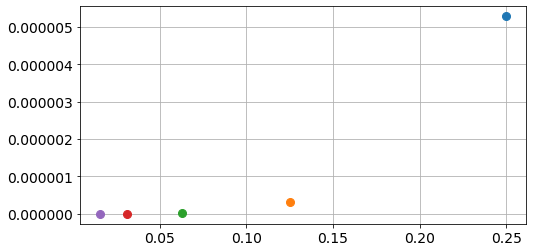

In [16]:
def composite_simpsons_rule(f, m, h, a, b):
    result = 0
    step = (b-a)/m
    x0 = a
    x1 = a+step
    for i in range(m):
        result += h/6 * (f(x0) + 4 * f((x0+x1)/2) + f(x1))
        x0 = x1
        x1 = x1 + step
    return result
h1 =2**-2
h2 =2**-3
h3 =2**-4
h4 =2**-5
h5 =2**-6
Q1 = composite_simpsons_rule(lambda x: np.cos(np.pi/2 * x), 4, 2**-2, 0, 1)
Q2 = composite_simpsons_rule(lambda x: np.cos(np.pi/2 * x), 8, 2**-3, 0, 1)
Q3 = composite_simpsons_rule(lambda x: np.cos(np.pi/2 * x), 16, 2**-4, 0, 1)
Q4 = composite_simpsons_rule(lambda x: np.cos(np.pi/2 * x), 32, 2**-5, 0, 1)
Q5 = composite_simpsons_rule(lambda x: np.cos(np.pi/2 * x), 64, 2**-6, 0, 1)
I = 2/np.pi

plot(h1, np.abs(I - Q1), 'o')
plot(h2, np.abs(I - Q2), 'o')
plot(h3, np.abs(I - Q3), 'o')
plot(h4, np.abs(I - Q4), 'o')
plot(h5, np.abs(I - Q5), 'o')
#Unsure if this is what you wanted me to do....
# Anyways, we see that 

Doubling the number of sub-intervals decreases the error by a factor of 16. This suggests that the error of the composite Simpson rule is $Cm^{-4} = Ch^4$.

**c)**
Recall that the error of Simpson's rule on a single interval is given by

$$
|I[f](a,b) - S[f](a,b)| = - \frac{(b-a)^5}{2880}  f^{(4)}(\xi)
$$
for some $\xi \in [a,b]$.

Use this to show that the error of the composite Simpson rule can be bounded by

\begin{equation}
|I[f]-\mathrm{CSR}[f]|
\leqslant
\dfrac{M_4}{2880} \dfrac{(b-a)^5}{m^4}
=
\dfrac{M_4}{2880}
h^4(b-a)
\label{quad:thm:csr_est} \tag{3}
\end{equation}

where  $M_4 = \max_{\xi\in[a,b]} |f^{(4)}(\xi)|$.

## 2) Gaussian Quadrature

In this exercise we will construct a Gaussian quadrature rule with 3 nodes. We will take it step by step, so don't worry if you do not feel like an expert on Gaussian quadrature. 

To make your life easy, we will use the [sympy](https://docs.sympy.org/latest/index.html#) python module  for symbolic mathematics to perform tasks such as (symbolic) integration and root finding of low order polynoms. 
In particular look at [integrate](https://docs.sympy.org/latest/modules/integrals/integrals.html) and [solve](https://docs.sympy.org/latest/modules/solvers/solvers.html) submodules.



The first step in constructing a Gaussian quadrature is finding the correct orthogonal polynomial. The nodes of the quadrature rule will be the roots of some polynomial. Since we are looking for 3 nodes, this means that the polynomial should have 3 roots, and hence we are looking for a third-order polynomial.
 
The polynomial, call it $p_3$, should be orthogonal on the interval $[0,3]$ to all polynomials of order 2 or less. We now create this polynomial.

Start with the 4 polynomial "basis" functions 
$$
\phi_0 = 1,\quad \phi_1 = x,\quad \phi_2 = x^2,\quad \phi_3 = x^3.
$$
Remember that on the interval $[0,3]$ we have the *inner product*
$$
(p,q) = \int_{0}^3p(x)\,q(x)\,\mathrm{d}x
$$
and the *norm*
$$
\|p\| = \left(\int_{0}^3 p(x)^2 \, \mathrm{d}x\right)^{1/2}.
$$

We can now construct orthogonal polynomials by using Gram-Schmidt orthogonalization.

\begin{align*}
p_k = \phi_k - \sum_{j=0}^{k-1}\frac{(\phi_k,p_j)}{\|p_j\|^2}\, p_j
\end{align*}

We start out by setting $p_0 = 1$. In order to calculate $p_1$ we first need to calculate
$$
(\phi_1,p_0) = \int_{0}^3\phi_1(x)\,p_0(x)\, \mathrm{d}x = \int_{0}^3 x \cdot 1 \, \mathrm{d}x = \left[\frac{x^2}{2}\right]^3_{0} = \frac{9}{2}.
$$
We also need to calculate
$$
\|p_0\|^2 = \int_{0}^3p_0(x)^2 \, \mathrm{d}x = \int_{0}^3 1\cdot 1 \mathrm{d}x = 3.
$$
Therefore, 
$$
p_1 = \phi_1 - \frac{(\phi_1,p_0)}{\|p_0\|^2}\,p_0 = \phi_1 - \frac{9/2}{3}\cdot p_0 = \phi_1 - \frac{3}{2}p_0 = x-\frac{3}{2}.
$$

**a)**

Use Gram-Schmidt orthogonalization to construct $p_2$ and $p_3$.

We can use the Python package SymPy to check our calculations. The code below helps you by defining the inner product and shows how to define polynomials.

In [3]:
from sympy.abc import x
from sympy import integrate

a=0
b=3

#Define the inner poduct
def scp(p,q):
    return integrate(p*q, (x, a, b))

#Define polynomials
p0 = 1
p1 = x

#Calculate the inner product and print it.
print(scp(p0,p1))

9/2


**b)**
Use the function $\texttt{scp}$ to check whether the polynomials you calculated
are in fact **orthogonal**.

**c)**
Find the 3 roots of $p_3$.

*Hints:*

 - Analytical approach: If you want to do it analytical, use the fact that one root is $$x=\frac{3}{2}$$
to find a second order polynomial $\widetilde{p}_2$ such that  $\widetilde{p}_2(x) \cdot (x-3/2) = p_3(x)$.
 - Computational approach: 
If you want to use a computational algebra system/symbolic calculator
you Import the `solve` from `sympy` (Have a look at the
[solve](https://docs.sympy.org/latest/modules/solvers/solvers.html) submodules.)

**d)**

Let's denote the three roots of $p_3$ by $x_1,x_2,x_3.$

Construct the three Lagrange polynomials $L_1, \, L_2,\,  L_3$ satisfying $L_i(x_j) = \delta_{ij},$ that is

$$
L_i(x_j) = 
\begin{cases}
1,\quad i=j,\\
0,\quad i\neq j.
\end{cases}
$$

Then calculate the weights 
$$
w_i = \int_{0}^3L_i(x)\, \mathrm{d}x.
$$

*Hint: You can use the SymPy function $\texttt{integrate}$ to check your calculations.*

**e)** 

Now recheck your calculations as follows.
The Gauss-Legendre rule for the interval $[-1,1]$ with $3$ quadrature points is given by
\begin{align*}
\{\hat{x}_i\}_{i=0}^2 &= \left\{-\sqrt{\tfrac{3}{5}}, 0, \sqrt{\tfrac{3}{5}} \right\}
\\
\{\hat{w}_i\}_{i=0}^2 &= \left\{ \tfrac{5}{9}, \tfrac{8}{9}, \tfrac{5}{9} \right\}
\end{align*}
Now transfer this quadrature rule to the interval $[0,3]$ and confirm that you get the same quadrature points and weights you computed in 2a)-2d).

**f)**

Finally, write down the quadrature rule on the form

$$
\mathrm{GQR}[f](0,3) = \sum_{j=1}^nw_jf(x_j).
$$

and check that this Gaussian quadrature rule has degree of exactness equal to $5$.

*Hint: Use the `QR` function from the `SimpleQuadrature.ipynb` notebook.*